# OpenStreetMap Data Case Study

在本次项目中，我选择研究的城市是澳大利亚第一大城市悉尼($Sydney,Austrilia$)。
* https://www.openstreetmap.org/relation/5750005   
* https://mapzen.com/data/metro-extracts/metro/sydney_australia/ 

## $1.$观察数据
本地$osm$文件的大小约为328MB

In [87]:
ls -l sydney_australia.osm

-rw-r--r--@ 1 missu  staff  328496448 10 17 15:30 sydney_australia.osm


首先从原文件中选取标签为$node$或者$way$的元素以及它们的子元素作为研究对象，再从这些元素中选取$1/20$作为一个小样本，对样本中的数据进行简单的观察。

In [2]:
import xml.etree.cElementTree as ET 

OSM_FILE = 'sydney_australia.osm'
SAMPLE_FILE = "sample.osm"
k = 20

def get_element(osm_file, tags=('node', 'way')):
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n')
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))
    output.write('</osm>')

遍历样本文件，输出出现的所有标签名和它们出现的次数。

In [6]:
from collections import defaultdict
tags = defaultdict(lambda: 0)
for event,element in ET.iterparse(SAMPLE_FILE):
    tags[element.tag] +=1
tags

defaultdict(<function __main__.<lambda>>,
            {'nd': 87432, 'node': 72895, 'osm': 1, 'tag': 40867, 'way': 10010})

样本文件中出现的标签有：

- $osm,unique$
- $node$,记录节点数据，样本中共有72895个节点
- $way$,记录路径数据，样本中共有72895个节点
- $nd$,出现87432次，作为$way$的子标签，记录$way$中包含的$node$
- $tags$,出现40867次，作为$node$或$way$的子标签，记录$node$和$way$的信息
------
对每种标签，输出其元素包含的属性值,并验证是否有元素包含的属性与其它元素不一致：

In [7]:
for keys in tags:
    for event,element in ET.iterparse(SAMPLE_FILE):
        if element.tag == keys:
            attributes = element.attrib.keys()
            print'{} attributes:'.format(keys),attributes
            break
    for event,element in ET.iterparse(SAMPLE_FILE):
        if element.tag == keys:
            if element.attrib.keys() != attributes:
                print 'Error:',element.attrib

node attributes: ['changeset', 'uid', 'timestamp', 'lon', 'version', 'user', 'lat', 'id']
osm attributes: []
tag attributes: ['k', 'v']
nd attributes: ['ref']
way attributes: ['changeset', 'uid', 'timestamp', 'version', 'user', 'id']


幸运的是，数据集中每种标签的元素都拥有相同的属性，没有出现缺失、多余或不一致的情况。  

------
为了对每个标签的数据进行审核和完善，需要首先知道每个标签中数据的内容。

In [8]:
for keys in tags:
    for i,element in ET.iterparse(SAMPLE_FILE):
        if element.tag == keys:
            print element.tag,element.attrib
            break

node {'changeset': '4228056', 'uid': '20949', 'timestamp': '2010-03-25T10:25:53Z', 'lon': '151.1888395', 'version': '3', 'user': 'Ebenezer', 'lat': '-33.9176762', 'id': '324883'}
osm {}
tag {'k': 'crossing', 'v': 'traffic_signals'}
nd {'ref': '20827842'}
way {'changeset': '52055519', 'uid': '717576', 'timestamp': '2017-09-15T01:26:08Z', 'version': '16', 'user': 'samuelrussell', 'id': '1884057'}


## $2.$数据的审核与完善
通过正则表达式，依次对每个标签中的数据进行审核，并完善出现问题的数据。

* $changeset／uid／id／ref$属性中合理的值的类型为一个长的正整数
* $version$属性中合理的值的类型为一个短的正整数
* $timestamp$属性中合理的值为特定的时间格式:XXXX-XX-XX'T'XX:XX:XX'Z'
* $lon／lat$属性中合理的值为可能带负号的浮点数
* $k$属性中合理的值为混杂小写字母数字和下划线的字符串，其中可能有冒号
* $user$属性是用户名，值中可能包含多种语言，格式较为混乱，因此不进行审查
* $v$属性中的值为$k$对应的数据的值，数据格式与$k$的值有关，其审查将放在后续进行

由此写出每个属性对应合理值的正则表达式

In [9]:
import re
pattern = {}
pattern['changeset']=pattern['id']=pattern['uid']=pattern['ref']=pattern['version'] = re.compile(r'^\d+$')
pattern['version'] = re.compile(r'^[1-9][0-9]{0,2}$')
pattern['timestamp'] = re.compile(r'^[1-2]\d{3}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z$')
pattern['lon']=pattern['lat'] = re.compile(r'^-?(\d{1,3}\.\d*)$')
pattern['k'] = re.compile(r'^([a-z0-9]|_)*(:([a-z0-9]|_)*)*$')
pattern['v']=pattern['user'] = re.compile(r'.*')

In [10]:
for event,element in ET.iterparse(SAMPLE_FILE):
    for key,value in element.attrib.iteritems():
        if not pattern[key].search(value):
            print key,value

k Hours
k Keywords
k State
k FIXME
k FIXME
k FIXME
k FIXME
k Id
k Floor_Coun
k Brush
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Brush
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Brush
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Floor_Coun
k Room_Count
k Floor_Coun
k Room_Count
k Floor_Coun
k Room_Count
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k Floor_Coun
k Floor_Coun
k Room_Count
k LAYER
k GM_TYPE
k Item_ID
k Origin_X
k Origin_Y
k Origin_Z
k Item_class
k u-turn
k parking:lane:right:perpendicular:off-street
k LAYER


审查结果发现，除$k$属性外的其余标签中的值都是合理的。   
观察可以发现，$k$属性中的异常值有两个来源：大写字母和短横线'$-$'。    
本项目中不处理短横线'$-$'，但会把大写字母全部转为小写。   
定义函数 $'better\_tag'$ ,后续对$tag$内容的完善都将通过这个函数实现。   

In [11]:
def better_tag(element):
    element.tag = element.tag.lower()
    return element

为了审查$v$属性中的值，先按照不同的$k$值进行分类。

In [12]:
keys = defaultdict(lambda: 0)
for event,element in ET.iterparse(SAMPLE_FILE):
    if element.tag == 'tag':
        keys[element.attrib['k']] += 1     
keys= sorted(keys.iteritems(), key=lambda d:d[1], reverse = True)
keys[:20]

[('highway', 7283),
 ('name', 4946),
 ('source', 4823),
 ('building', 2008),
 ('surface', 1298),
 ('maxspeed', 1261),
 ('oneway', 1012),
 ('addr:street', 959),
 ('amenity', 886),
 ('source:name', 657),
 ('created_by', 616),
 ('noname', 615),
 ('foot', 603),
 ('leisure', 560),
 ('addr:housenumber', 526),
 ('bicycle', 512),
 ('service', 407),
 ('addr:postcode', 407),
 ('lanes', 379),
 ('layer', 349)]

因为$k$的取值太多，本次项目中我将只选取出现最多的5个$k$值，对这5个$k$相应的的$v$值进行审核与完善。

In [90]:
keys[:5]

[('highway', 7283),
 ('name', 4946),
 ('source', 4823),
 ('building', 2008),
 ('surface', 1298)]

定义一个函数，用来计算对于某个特定的$k$值，$v$可能的取值和每个取值出现的次数。

In [14]:
def count_value(keyword):
    key_dict = defaultdict(lambda:0)
    for event,element in ET.iterparse(SAMPLE_FILE):
        if element.tag == 'tag' and element.attrib['k'] == keyword:
            key_dict[element.attrib['v']] += 1     
    key_dict = sorted(key_dict.iteritems(), key=lambda d:d[1], reverse = True)
    return key_dict

调用函数计算当$k$取值为highway时，$v$的不同取值和出现频次。

In [15]:
count_value('highway')[:20]

[('residential', 2399),
 ('service', 902),
 ('footway', 729),
 ('turning_circle', 533),
 ('tertiary', 361),
 ('bus_stop', 342),
 ('secondary', 258),
 ('path', 247),
 ('traffic_signals', 221),
 ('cycleway', 210),
 ('crossing', 172),
 ('primary', 170),
 ('track', 128),
 ('unclassified', 126),
 ('trunk', 119),
 ('steps', 107),
 ('motorway_link', 55),
 ('motorway', 39),
 ('pedestrian', 27),
 ('give_way', 24)]

可以看到当$k$取值$highway$时，对应的$v$值出现最多的是$residential$     
没有出现明显有问题的取值，无需进行额外的完善。

-------
$k$取值$name$时，对应的$v$值是这一地点的名称，取值格式很多样，因此不对这组$v$值进行审查。   
下面计算$k$取值为$source$时，$v$的不同取值。

In [16]:
count_value('source')[:20]

[('survey', 1220),
 ('nearmap', 1064),
 ('Bing', 913),
 ('bing', 326),
 ('GPS survey', 118),
 ('NSW LPI Imagery', 98),
 ('yahoo', 81),
 ('local_knowledge', 77),
 ('yahoo_imagery', 76),
 ('ABS2011-data.gov.au', 66),
 ('PGS', 57),
 ('knowledge', 44),
 ('NSW LPI Base Map', 44),
 ('Yahoo maps', 43),
 ('NSW LPI', 43),
 ('professional_knowledge;extrapolation', 37),
 ('GPS', 32),
 ('Yahoo', 28),
 ('nswgnb', 27),
 ('bing;professional_knowledge', 19)]

当$k$取值$source$时，得到了多样化的取值，不难发现其中有很多需要优化的地方：
* 由于大小写的不统一，很多相同来源的数据被归到了不同来源，比如'Bing'／'bing'，'yahoo'／'Yahoo'等；
* 很多不同的表述其实指向的是同一个数据来源，比如'NSW LPI Base Map'/'NSW LPI Imagery'/'NSW LPI'指的都是澳大利亚新南威尔士政府的Land and Property Information数据，'GPS survey'／'GPS'指的都是来源于GPS的数据；
* 很多$v$值中包含了多种数据来源，它们由','／';'/'+'等符号分割，比如'survey;Bing'／'bing + knowledge'等
* 取值中还有一些错别字，比如'neamap'／'PGS'（因为在[PGS的wikipedia页面](https://en.wikipedia.org/wiki/PGS)没有找到合理的解释，我认为它是'GPS'的错误输入）    
------
我的处理方法是：
* 筛选出包含','/';'/'+'等连接符的字符串，把它们的$v$值记为'multi-methods'，即通过多种方式获得；
* 预设几个关键字如'Bing'／'NSW LPI'／'Yahoo'／'GPS'等，对每个关键字建立正则表达式，并用re.I方法无视大小写。如果字符串成功匹配了某个关键字，就把关键字设定为新的$v$值。比如所有包含'gps'的$v$值都会被改写为'GPS'，所有包含'bing'的$v$值都会被改写为'Bing'。

In [18]:
# 预设的关键字包括：GPS,survey,Bing,Yahoo,NSW LPI,knowledge,nearmap,ABS(澳大利亚统计局)以及 multi-methods
source_pattern = {}
source_pattern['multi-methods'] = re.compile(r'[+;,]')
source_pattern['GPS'] = re.compile(r'GPS|PGS',re.I)
source_pattern['survey'] = re.compile(r'(?<!GPS )survey',re.I) # GPS survey应属于GPS
source_pattern['Bing'] = re.compile(r'Bing',re.I)
source_pattern['Yahoo'] = re.compile(r'Yahoo',re.I)
source_pattern['NSW LPI'] = re.compile(r'NSW|LPI',re.I)
source_pattern['knowledge'] = re.compile(r'knowledge',re.I)
source_pattern['nearmap'] = re.compile(r'nearmap|neamap',re.I)
source_pattern['ABS'] = re.compile(r'ABS',re.I)

In [19]:
source_list = ['multi-methods','GPS','survey','Bing','Yahoo','NSW LPI','knowledge','nearmap','ABS']
source_dict = defaultdict(lambda:0)
for event,element in ET.iterparse(SAMPLE_FILE):
    if element.tag == 'tag' and element.attrib['k'] == 'source':
        v_value = element.attrib['v']
        for source in source_list:
            if source_pattern[source].search(v_value):
                element.attrib['v'] = source
                break
        source_dict[element.attrib['v']] += 1
source_dict = sorted(source_dict.iteritems(), key=lambda d:d[1], reverse = True)
source_dict[:20]

[('Bing', 1263),
 ('survey', 1228),
 ('nearmap', 1069),
 ('Yahoo', 286),
 ('NSW LPI', 245),
 ('multi-methods', 236),
 ('GPS', 215),
 ('knowledge', 135),
 ('ABS', 73),
 ('historical', 8),
 ('UWS Capital Works & Facilities', 6),
 ('Collected via KeypadMapper', 6),
 ('photo', 5),
 ('interpolation', 5),
 ('Mapbox', 5),
 ('voice', 5),
 ('sign', 4),
 ('digitalglobe', 2),
 ('http://taronga.org.au/taronga-zoo/map-visit-planner', 2),
 ('UWS Capital Works and Facilities', 2)]

这是经过修正后的$source$数据，'Bing'成为了最主要的来源。

In [20]:
count_value('building')[:20]

[('yes', 939),
 ('house', 512),
 ('garage', 186),
 ('apartments', 85),
 ('industrial', 47),
 ('residential', 37),
 ('commercial', 37),
 ('school', 36),
 ('retail', 22),
 ('roof', 20),
 ('university', 18),
 ('terrace', 13),
 ('church', 11),
 ('warehouse', 5),
 ('office', 4),
 ('hospital', 4),
 ('train_station', 3),
 ('flats', 3),
 ('shed', 2),
 ('college', 2)]

计算$k$取值$building$时，对应$v$的取值，发现出现最多的是$yes$       
除了$yes$外，其它取值都描述了建筑的类型，没有明显出现问题的取值，无需额外优化。

In [21]:
count_value('surface')[:20]

[('asphalt', 567),
 ('paved', 381),
 ('unpaved', 113),
 ('concrete', 109),
 ('grass', 31),
 ('ground', 29),
 ('dirt', 19),
 ('gravel', 13),
 ('sand', 9),
 ('paving_stones', 5),
 ('cobblestone', 4),
 ('wood', 3),
 ('bricks', 2),
 ('brick', 2),
 ('gravel;ground', 2),
 ('metal', 2),
 ('concrete;gravel;ground', 1),
 ('pebblestone', 1),
 ('flagstones', 1),
 ('gravel;sand;rock', 1)]

$surface$数据记录了地表覆盖的类型。   
和上述的处理方式类似，我会把带分号项的$v$值记为$mixed$，其他数据保持不变。

In [125]:
surface_dict = defaultdict(lambda:0)
for event,element in ET.iterparse(SAMPLE_FILE):
    if element.tag == 'tag' and element.attrib['k'] == 'surface':
        v_value = element.attrib['v']
        if ';' in v_value:
            element.attrib['v'] = 'mixed'
        surface_dict[element.attrib['v']] += 1
surface_dict = sorted(surface_dict.iteritems(), key=lambda d:d[1], reverse = True)
surface_dict

[('asphalt', 567),
 ('paved', 381),
 ('unpaved', 113),
 ('concrete', 109),
 ('grass', 31),
 ('ground', 29),
 ('dirt', 19),
 ('gravel', 13),
 ('sand', 9),
 ('paving_stones', 5),
 ('mixed', 5),
 ('cobblestone', 4),
 ('wood', 3),
 ('bricks', 2),
 ('metal', 2),
 ('brick', 2),
 ('steel', 1),
 ('pebblestone', 1),
 ('flagstones', 1),
 ('rock', 1)]

课程中已经编写了对街道名进行审查和优化的函数，对应的是$k$取$addr:street$的情况。

In [22]:
mapping = { 'St': 'Street','St.': 'Street','Ave':'Avenue','Ave.':'Avenue','Rd':'Road','Rd.':'Road'}
street_type_re = re.compile(r'\b\S+\.?$',re.I)
street_dict = defaultdict(lambda:0)
for event,element in ET.iterparse(SAMPLE_FILE):
    if element.tag == 'tag' and element.attrib['k'] == 'addr:street':
        v_value = element.attrib['v']
        street_type = street_type_re.search(v_value).group()
        if street_type in mapping:
            element.attrib['v'] = v_value.replace(street_type,mapping[street_type])
        else:
            element.attrib['v'] = v_value.replace(street_type,street_type.title())
        street_dict[street_type_re.search(element.attrib['v']).group()] += 1
street_dict = sorted(street_dict.iteritems(), key=lambda d:d[1], reverse = True)
street_dict[:20]

[('Street', 432),
 ('Road', 246),
 ('Avenue', 145),
 ('Parade', 27),
 ('Drive', 23),
 ('Crescent', 17),
 ('Highway', 16),
 ('Place', 16),
 ('Circuit', 8),
 ('Wolli', 4),
 ('Court', 3),
 ('Way', 3),
 ('Close', 3),
 ('Lane', 2),
 ('Square', 2),
 ('Boulevard', 1),
 ('West', 1),
 ('East', 1),
 ('Clontarf', 1),
 ('Plaza', 1)]

这些数据的完善过程都可以整合到函数 $'better\_tag'$ 中：

In [126]:
def better_tag(element):
    element.tag = element.tag.lower()
    if element.attrib['k'] == 'source':
        source_value = element.attrib['v']
        for source in source_list:
            if source_pattern[source].search(source_value):
                element.attrib['v'] = source
                break
    elif element.attrib['k'] == 'surface':
        surface_value = element.attrib['v']
        if ';' in surface_value:
            element.attrib['v'] = 'mixed'
    elif element.attrib['k'] == 'addr:street':
        v_value = element.attrib['v']
        street_type = street_type_re.search(v_value).group()
        if street_type in mapping:
            element.attrib['v'] = v_value.replace(street_type,mapping[street_type])
        else:
            element.attrib['v'] = v_value.replace(street_type,street_type.title())
    return element

## $3.$建立SQL数据库
由$osm$数据建立$SQL$数据库的过程大致可以分为三步：   
$step 1$:通过 $'shape\_element'$ 函数，把需要导入数据库的数据从$osm$文件中提取出来，转换为几个$dictionaries$

In [148]:
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS, default_tag_type='regular'):

    node_attribs,way_attribs = {},{}
    way_nodes,tags = [],[]

    if element.tag =='node':
        for node_attr in NODE_FIELDS:
            node_attribs[node_attr] = element.attrib[node_attr]
    if element.tag =='way':
        for way_attr in WAY_FIELDS:
            way_attribs[way_attr] = element.attrib[way_attr]
            
    count = 0        
    for child in element:
        if child.tag == 'tag':
            child = better_tag(child) #调用 better_tag函数更新tag中的数据
            tag_info = {}
            tag_info['id'] = element.attrib['id']
            tag_info['value'] = child.attrib['v']
            if ':' not in child.attrib['k']:
                tag_info['type'] = 'regular'
                tag_info['key'] = child.attrib['k']
            else:
                type_k = child.attrib['k'].split(':')[0]
                tag_info['type'] = type_k
                tag_info['key'] = child.attrib['k'].replace(type_k+':','')
            tags.append(tag_info)
        elif child.tag == 'nd':
            nd_info = {}
            nd_info['id'] = element.attrib['id']
            nd_info['node_id'] = child.attrib['ref']
            nd_info['position'] = count
            count += 1
            way_nodes.append(nd_info)
        
    if element.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

$step 2$:通过 $ 'get\_element'$ 和 $'process\_map'$ 函数，把数据写入$csv$文件。

In [149]:
import csv
import codecs
import pprint

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"   

def get_element(osm_file, tags=('node', 'way')):
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

class UnicodeDictWriter(csv.DictWriter, object):
    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })
    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

def process_map(file_in):

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
        codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
        codecs.open(WAYS_PATH, 'w') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file,\
        codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

In [150]:
process_map(OSM_FILE)

$step 3:$ 在Terminal中运行sqlite3，新建数据库并把$csv$文件导入数据库中   

-------
.read data_wrangling_schema.sql   
.mode csv  
.import ways_nodes.csv ways_nodes  
.import ways.csv ways  
.import ways_tags.csv ways_tags  
.import nodes.csv nodes  
.import nodes_tags.csv nodes_tags  

## $4.$探索数据库   
使用 DB-API 连接本地数据库

In [1]:
import sqlite3
conn = sqlite3.connect('osm_Sydney.db')
cursor = conn.cursor()

查询本地数据库文件的大小，约为175MB

In [54]:
ls -l *.db

-rw-r--r--  1 missu  staff  175165440 10 19 22:29 osm_Sydney.db


In [9]:
count_nodes = cursor.execute('SELECT COUNT(*) FROM NODES')
print count_nodes.fetchall()

[(1457894,)]


In [10]:
count_ways = cursor.execute('SELECT COUNT(*) FROM WAYS')
print count_ways.fetchall()

[(200195,)]


分别查询数据集中$nodes$和$ways$的数目，发现共有1457894个节点，和200195条路径。

In [67]:
way_length = cursor.execute('''SELECT MAX(position)+1 as max,id
                               FROM ways_nodes 
                               GROUP BY id 
                               ORDER BY max DESC
                               LIMIT 10''')
#position是从0开始计数的，所以节点数目是MAX(position)+1
way_length.fetchall()

[(1789, 149668786),
 (1305, 310457827),
 (1180, 150905541),
 (1110, 149949600),
 (943, 149553706),
 (936, 398644134),
 (923, 414632940),
 (901, 224602856),
 (843, 366387557),
 (837, 225080521)]

从$ways\_nodes$表格计算每条路上的节点个数，并按节点数从大到小排序发现最多的一条路上有1789个节点

In [71]:
longest_way = cursor.execute('''SELECT ways.user,ways.timestamp,ways_tags.type, ways_tags.key,ways_tags.value
                                FROM ways
                                JOIN ways_tags ON ways.id = ways_tags.id
                                WHERE ways.id = 149668786''')
longest_way.fetchall()

[(u'SveLil', u'2012-07-23T07:12:19Z', u'regular', u'source', u'ABS'),
 (u'SveLil', u'2012-07-23T07:12:19Z', u'regular', u'natural', u'coastline')]

为了了解这条最长路径的更多信息，需要把$ways$和$ways_tags$连接，并查询这条道路的id    
发现这条路由用户'SveLil'最后于2012年7月23日编辑，ways_tags中的信息这条路的信息来源是ABS，属于海岸线。

In [62]:
nodes_per_way = cursor.execute('''  SELECT COUNT(*),AVG(max)
                                    FROM 
                                    (SELECT MAX(position)+1 as max
                                    FROM ways_nodes 
                                    GROUP BY id) as SUBSELECT ''')
nodes_per_way.fetchall()

[(200195, 8.749669072654163)]

为了计算每条路上的平均节点个数，需要把之前的查询作为子查询，调用AVG函数计算平均值  
结果发现对于全部200195条路径，每条路径上平均有8.75个节点。

---
值得一提的是，这样计算的平均节点数比简单用总路径数除以总节点数得到的结果要大出很多   
这应该是源于位于路径交叉口的节点同时被多条路径包含了，如果计算一下会发现这类交叉路口的节点占了节点总数的20%

In [49]:
total_nodes,total_ways,avg_nodes = 1457894,200195,8.749669072654163
cross_nodes = total_ways*avg_nodes-total_nodes
cross_nodes/total_nodes

0.20148652782712598

In [58]:
count_user = cursor.execute(''' SELECT COUNT(DISTINCT all_user.uid)
                                FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) as all_user ''')
count_user.fetchall()

[(2290,)]

In [175]:
best_user = cursor.execute('''SELECT all_user.user,COUNT(*) as num
                              FROM (SELECT uid,user FROM nodes UNION ALL SELECT uid,user FROM ways) as all_user 
                              GROUP BY all_user.uid
                              ORDER BY num DESC
                              LIMIT 10 ''')
best_user = best_user.fetchall()
best_user

[(u'balcoath', 117377),
 (u'inas', 89685),
 (u'TheSwavu', 74845),
 (u'aharvey', 64627),
 (u'ChopStiR', 60780),
 (u'Leon K', 48656),
 (u'cleary', 42783),
 (u'Rhubarb', 40855),
 (u'AntBurnett', 37624),
 (u'Warin61', 37149)]

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

计算为这个$osm$做出贡献的用户数目和作出贡献做多的用户，发现共有2290名用户    
作出贡献最多的用户是'balcoath'，他／她编写了117377个节点或路径的数据   
可视化结果如下图

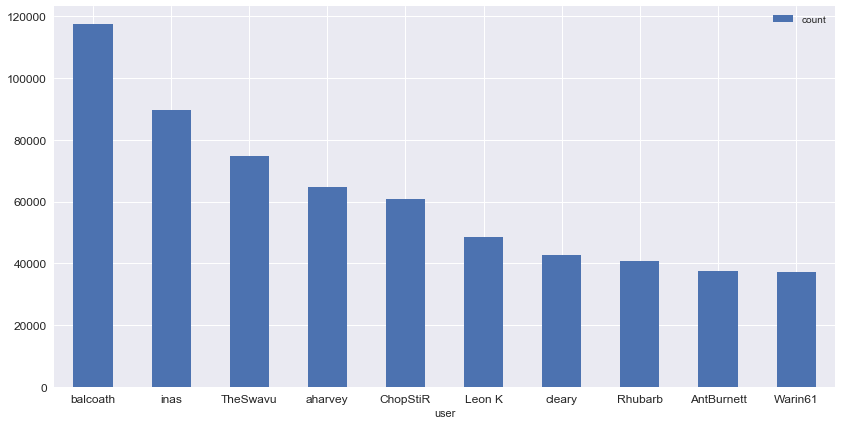

In [177]:
user_df = pd.DataFrame(best_user,columns=['user','count'])
user_df.set_index(user_df['user']).plot(kind='bar',fontsize='large',rot=0,figsize=(14,7))

In [183]:
source = cursor.execute(''' SELECT tags.value,COUNT(*) as num
                            FROM 
                            (SELECT * FROM nodes_tags
                            UNION ALL
                            SELECT * FROM ways_tags) as tags
                            WHERE tags.key = 'source'
                            GROUP BY tags.value
                            ORDER BY num DESC
                            LIMIT 10
                            ''')
source = source.fetchall()
source

[(u'Bing', 25697),
 (u'survey', 24217),
 (u'nearmap', 21753),
 (u'Yahoo', 5930),
 (u'NSW LPI', 5148),
 (u'multi-methods', 4906),
 (u'GPS', 4434),
 (u'knowledge', 2533),
 (u'ABS', 1233),
 (u'default residential speed limit in Australia', 428)]

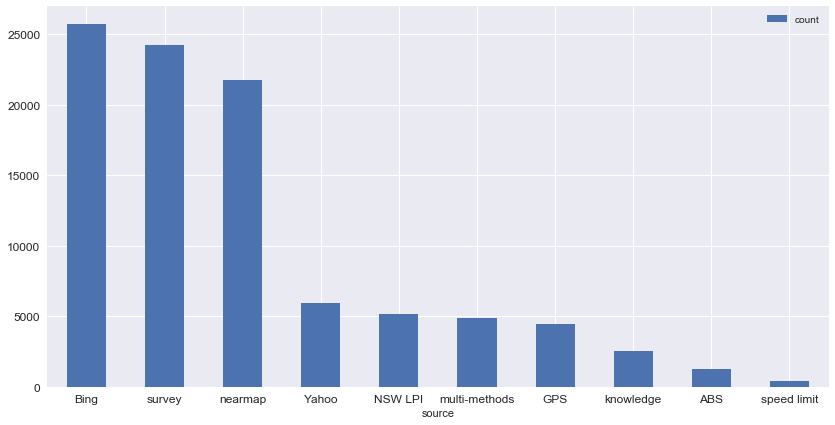

In [185]:
source_df = pd.DataFrame(source,columns=['source','count'])
source_df.iloc[9,0] = 'speed limit'
source_df.set_index(source_df['source']).plot(kind='bar',fontsize='large',rot=0,figsize=(14,7))

查询$source$项，与在样本中看到的结果相似，前文中预设的九个关键字占据了前九名，Bing依然是最主要的数据来源，然后依次是survey,nearmap等

In [186]:
surface = cursor.execute(''' SELECT value,COUNT(*) as num
                            FROM ways_tags
                            WHERE key = 'surface'
                            GROUP BY value
                            ORDER BY num DESC
                            LIMIT 10
                            ''')
surface = surface.fetchall()

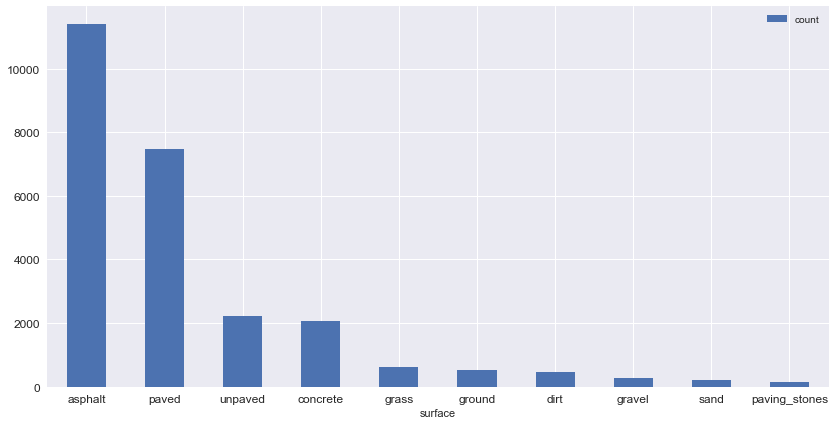

In [187]:
surface_df = pd.DataFrame(surface,columns=['surface','count'])
surface_df.set_index(surface_df['surface']).plot(kind='bar',fontsize='large',rot=0,figsize=(14,7))

对地表覆盖$surface$的查询是相似的，柏油路面是最主要的类型。

## $5.Other\space Ideas$
对于这次数据分析过程，我印象最深刻的是对$tag$标签中$v$值的审查和完善，或者说除了$v$值外数据的完整性和一致性还是比较好的，不需要太多的处理。在我自己尝试在$osm$上编辑地图后，我发现$v$值的杂乱源于它大多是完全手动输入的，比如$resource$完全没有预设值，这导致大家输入的值可能多种多样，即使他们试图描述的是同一样事物   
我的建议是，在输入$v$值的地方多设置一些预设选项，比如$resource$下的$Bing$、$survey$、$GPS$，或是$fast\_food$中的$McDonald's$、$Subway$、$KFC$   
这样的问题是，世界各地的人可能倾向用不同的数据来源或者吃不同的快餐，所以更好的方式是让这些预设选项可以来自系统内部的统计结果，当系统统计出某个地区的人对某个特定$key$最经常填写的是哪几个值会后，就把这几个值设定成为这个$key$下预置的默认选项，我觉得减少人工输入是减少数据杂乱的最好方式

--------
另一个收获来源于当我试图分析悉尼的快餐店品牌时：

In [198]:
fast_food = cursor.execute(''' SELECT nodes_tags.value,COUNT(*) as num
                            FROM nodes_tags
                            JOIN (SELECT id FROM nodes_tags WHERE value = 'fast_food') as subselect
                            ON nodes_tags.id = subselect.id
                            WHERE nodes_tags.key ='name'
                            GROUP BY nodes_tags.value
                            ORDER BY num DESC
                            LIMIT 10
                            ''')
fast_food = fast_food.fetchall()

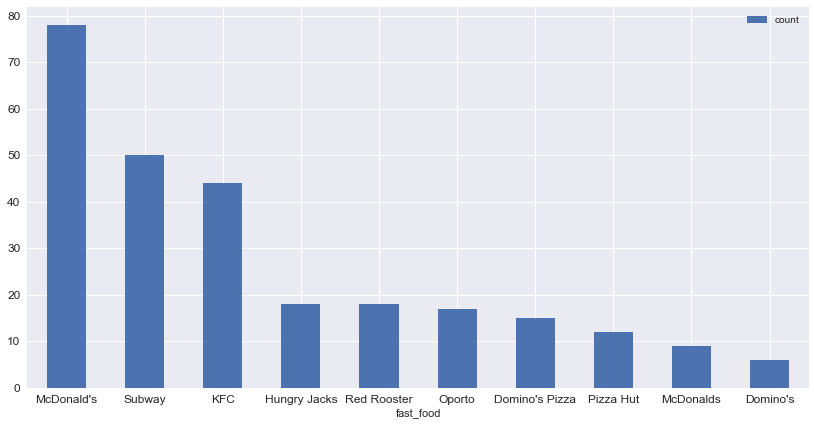

In [199]:
fast_food_df = pd.DataFrame(fast_food,columns=['fast_food','count'])
fast_food_df.set_index(fast_food_df['fast_food']).plot(kind='bar',fontsize='large',rot=0,figsize=(14,7))

我发现最多的是$McDonald's$,排行二三名的$Subway$和$KFC$同样占据了很大的数量，澳大利亚的本地快餐品牌从第四名才开始出现  
这时我发现，在第九名出现了一个新的$McDonalds$，这无疑是$McDonald's$的另一种书写，它们在数据清理阶段应该被归到一起    
可以想像的事，除了$McDonald's$外，其他的快餐品牌也会有很多别的书写方式，现在看到的数据中一定还会有很多别的问题，某种意义上这样的分析是“无效的”   
这次探索过程给了我一个教训：不要去分析和使用未经清理的数据，它们可能会给你有偏差甚至完全错误的结果，这一点也是课程中多次提及的

## $6.References$
* https://docs.python.org/2/library/re.html
* http://www.sqlitetutorial.net
* http://wiki.jikexueyuan.com/project/explore-python/Regular-Expressions/re.html
* http://blog.jobbole.com/55086/